<p style="font-family:consolas; font-size: 28px; color: magenta">Conditional GAN for generating MNIST digits in PyTorch</p>

In [1]:
'''
Conditional Generative Adversarial Networks (CGANs) are a specialized type of Generative Adversarial Network (GAN)
that generate data based on specific conditions such as labels or descriptions.
'''

'\nConditional Generative Adversarial Networks (CGANs) are a specialized type of Generative Adversarial Network (GAN) \nthat generate data based on specific conditions such as labels or descriptions.\n'

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Import libraries</p>

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.6.0+cu124
device: cuda


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Preparation the dataset</p>

In [10]:
'''
#MNIST dataset: A dataset of handwritten digits which contains 60,000 training images and 10,000 testing images.
#transforms.Resize: image size is changed from 28x28 to 64(X_DIM).
#transforms.ToTensor: Convert a PIL image or numpy.ndarray to tensor.
#transforms.Normalize: Normalize a tensor image with mean and standard deviation.
#Normalization ensures that the input data has a consistent scale,
#which can help models converge faster during training and improve performance
'''
# Data
train_data_path = './data/fashion-mnist_train.csv' # Path of data
valid_data_path = './data/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

Train data path: ./data/fashion-mnist_train.csv
Valid data path: ./data/fashion-mnist_test.csv


In [11]:
img_size = 28 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 1e-4

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Pytorch Dataset, DataLoader: Fashion MNIST</p>

In [6]:
class_list = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_num = len(class_list)

In [12]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])

        if self.transform:
            img = self.transform(img)

        return img, label

In [13]:
dataset = FashionMNIST(train_data_path, img_size)

Image size: (28390, 28, 28)
--- Label ---
label
7    2901
6    2890
0    2867
1    2855
8    2842
3    2841
5    2823
9    2823
2    2813
4    2735
Name: count, dtype: int64


<ipython-input-12-a13c2430c650>:5: RuntimeWarning: invalid value encountered in cast
  self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)


In [14]:
class_list[dataset[1][1]]

'Ankle boot'

In [15]:
dataset[1][0]

In [16]:
dataset[10][0]

In [17]:
class_list[dataset[10][1]]

'T-Shirt'

In [18]:
#transforms.ToTensor: Convert a PIL image or numpy.ndarray to tensor.
#transforms.Normalize: Normalize a tensor image with mean and standard deviation.
#Normalization ensures that the input data has a consistent scale,
#which can help models converge faster during training and improve performance
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [19]:
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Image size: (28390, 28, 28)
--- Label ---
label
7    2901
6    2890
0    2867
1    2855
8    2842
3    2841
5    2823
9    2823
2    2813
4    2735
Name: count, dtype: int64


<ipython-input-12-a13c2430c650>:5: RuntimeWarning: invalid value encountered in cast
  self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)


<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Plot training images</p>

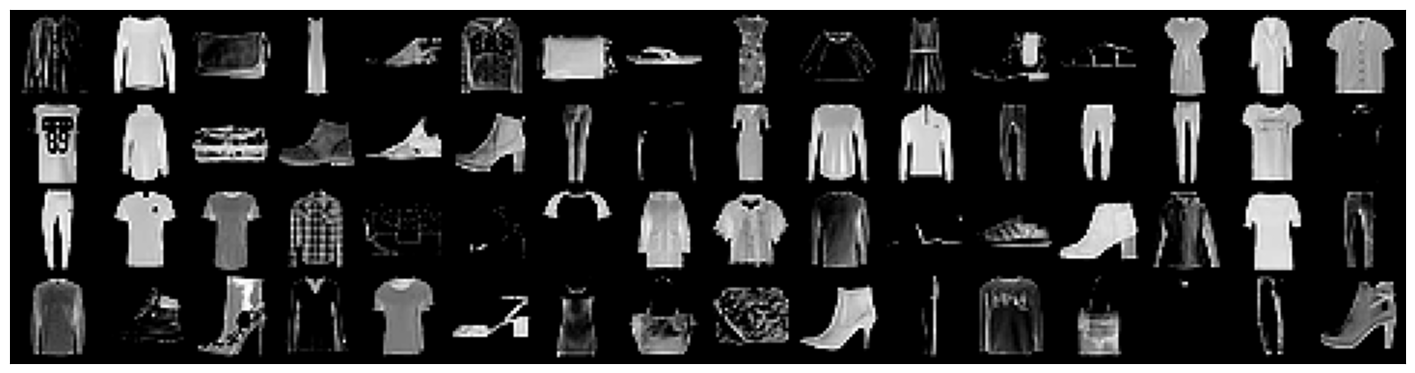

In [20]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Generator</p>

In [21]:

class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size

        self.label_emb = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )

    def forward(self, z, labels):

        # Reshape z
        z = z.view(-1, self.z_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([z, c], 1)

        # Generator out
        out = self.model(x)

        return out.view(-1, self.img_size, self.img_size)

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Discriminator</p>

In [22]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):

        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([x, c], 1)

        # Discriminator out
        out = self.model(x)

        return out.squeeze()

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Create the generator and the discriminator</p>

In [23]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Set up a loss function and optimizer</p>

In [24]:
'''
#Binary Cross Entropy loss (BCELoss) function is used for the loss function.
#ADAM is used for the optimizer.
'''
# Initialize BCELoss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

<p style="font-family:consolas; font-size: 26px; color: orange; text-decoration-line: overline; "> Training</p>

In [25]:
'''
The goal of training the generator is to minimize log(1−D(G(z)))in an effort to generate better fakes,
which means to maximize log(D(G(z))).
'''
'''
The goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake,
which is log(D(x))+log(1−D(G(z))).
'''

def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):

    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data

In [26]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):

    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    # Sum two losses
    d_loss = real_loss + fake_loss

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data

Starting epoch 1...
g_loss: 3.6652517318725586, d_loss: 0.09240614622831345


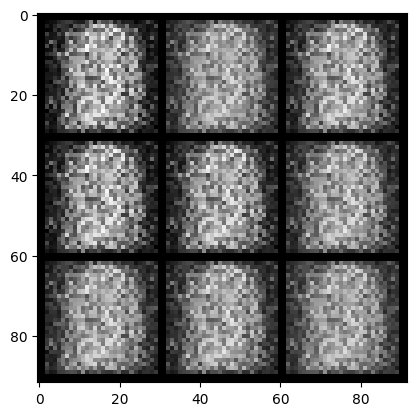

Starting epoch 2...
g_loss: 4.701572418212891, d_loss: 0.24437780678272247


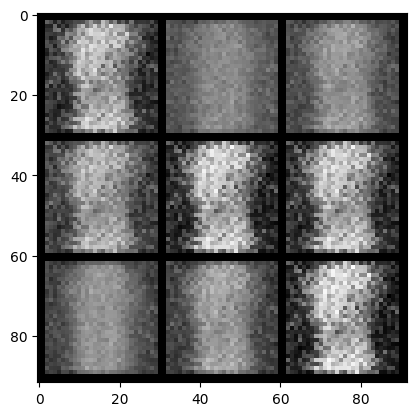

Starting epoch 3...
g_loss: 5.308171272277832, d_loss: 0.3881949782371521


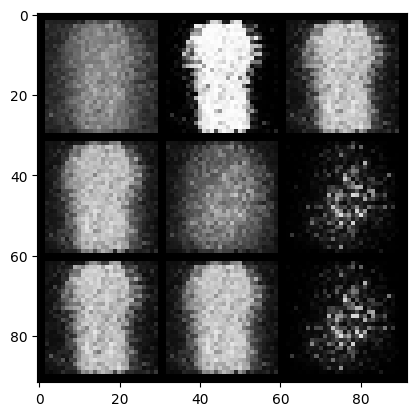

Starting epoch 4...
g_loss: 4.226466178894043, d_loss: 0.3726201355457306


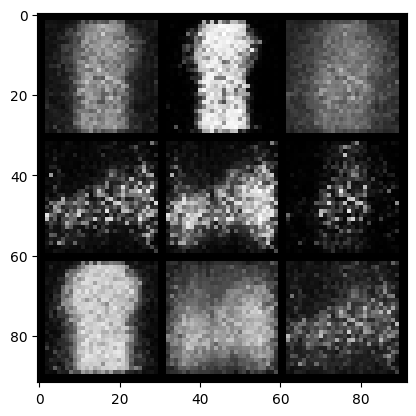

Starting epoch 5...
g_loss: 4.3419904708862305, d_loss: 0.21779362857341766


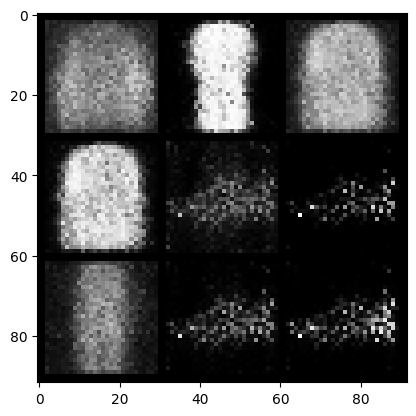

Starting epoch 6...
g_loss: 5.009064197540283, d_loss: 0.28541699051856995


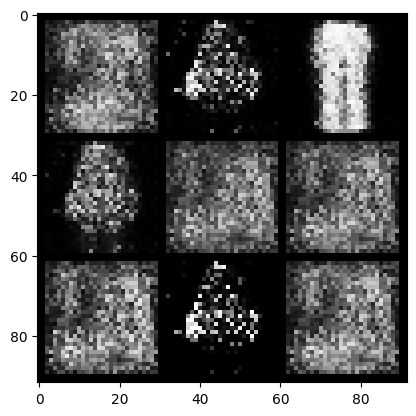

Starting epoch 7...
g_loss: 4.804034233093262, d_loss: 0.3601820468902588


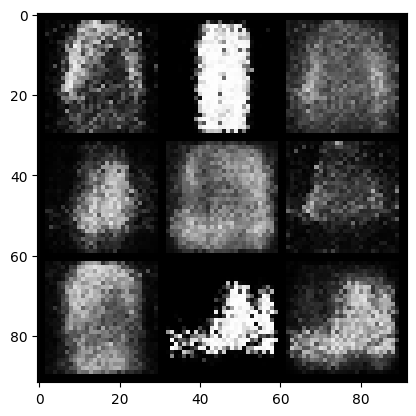

Starting epoch 8...
g_loss: 3.739013195037842, d_loss: 0.3520032465457916


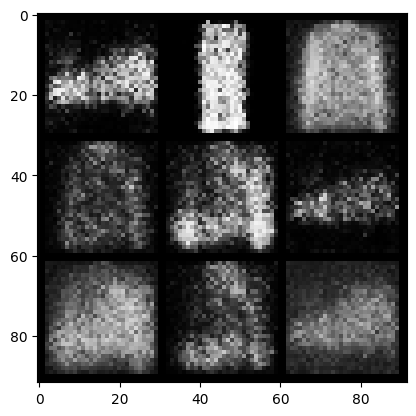

Starting epoch 9...
g_loss: 3.2061288356781006, d_loss: 0.5906696319580078


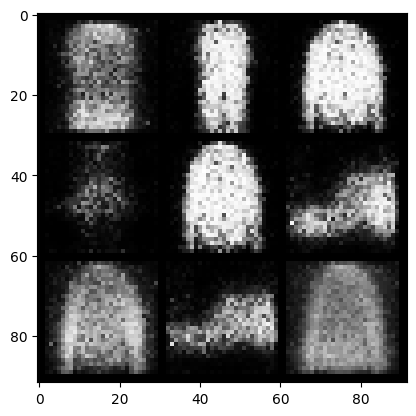

Starting epoch 10...
g_loss: 2.542764663696289, d_loss: 0.6302754878997803


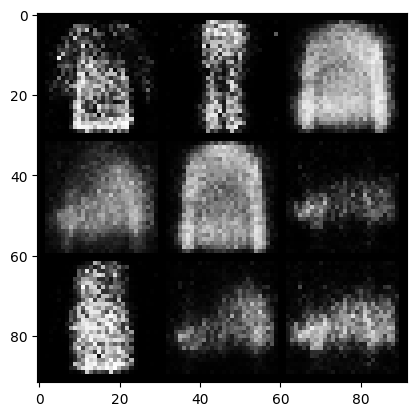

Starting epoch 11...
g_loss: 2.3028757572174072, d_loss: 0.6524969935417175


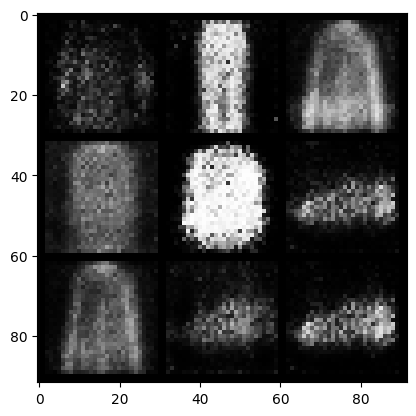

Starting epoch 12...
g_loss: 2.906510829925537, d_loss: 0.3846156597137451


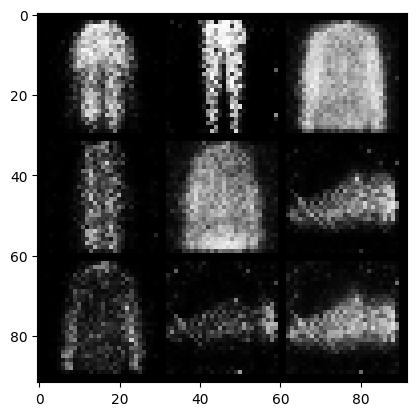

Starting epoch 13...
g_loss: 1.8019373416900635, d_loss: 1.140916109085083


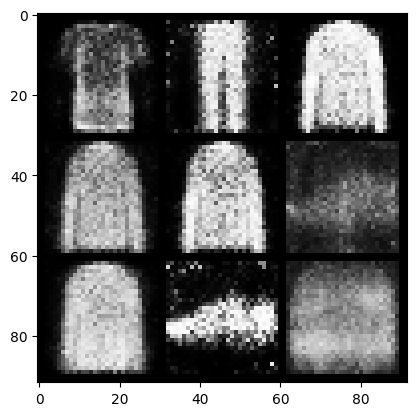

Starting epoch 14...
g_loss: 1.6080089807510376, d_loss: 0.7284877300262451


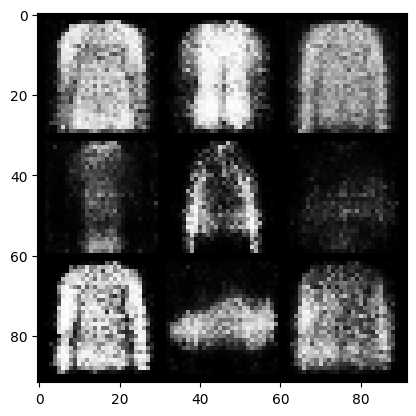

Starting epoch 15...
g_loss: 1.9215161800384521, d_loss: 1.1051161289215088


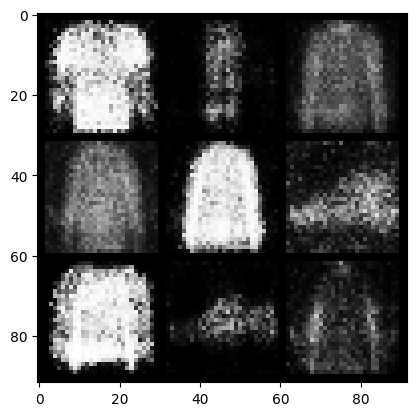

Starting epoch 16...
g_loss: 1.8469171524047852, d_loss: 0.7018567323684692


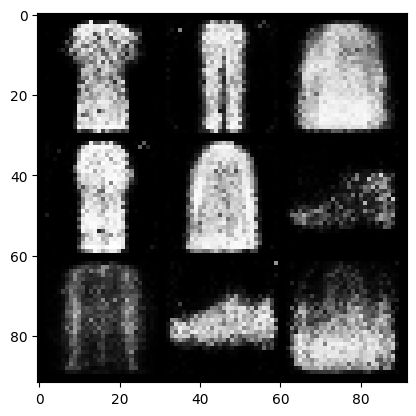

Starting epoch 17...
g_loss: 1.65022873878479, d_loss: 0.7025101184844971


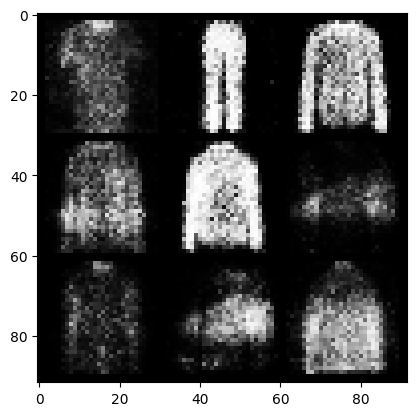

Starting epoch 18...
g_loss: 2.1275219917297363, d_loss: 0.6057475209236145


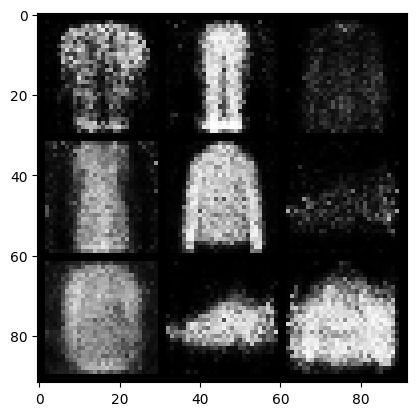

Starting epoch 19...
g_loss: 2.1263558864593506, d_loss: 0.6757461428642273


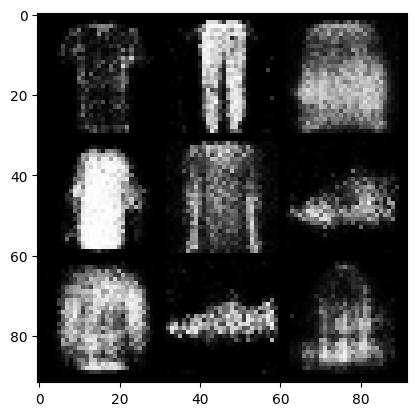

Starting epoch 20...
g_loss: 1.5543439388275146, d_loss: 1.0910236835479736


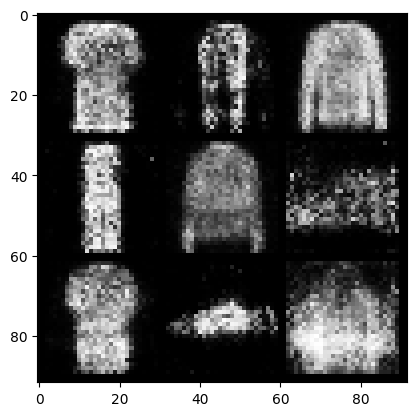

Starting epoch 21...
g_loss: 1.8542282581329346, d_loss: 0.9970593452453613


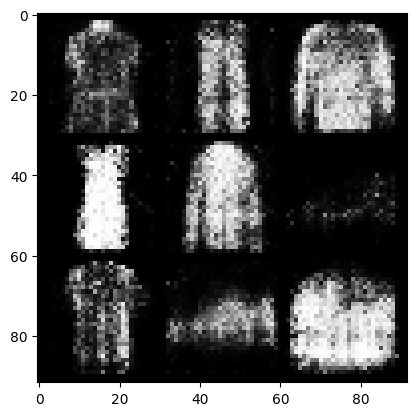

Starting epoch 22...
g_loss: 1.911232352256775, d_loss: 1.2027366161346436


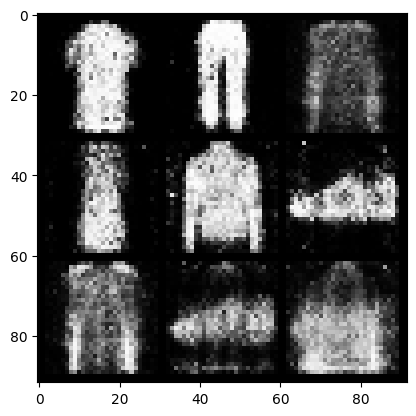

Starting epoch 23...
g_loss: 1.4844341278076172, d_loss: 0.9667454957962036


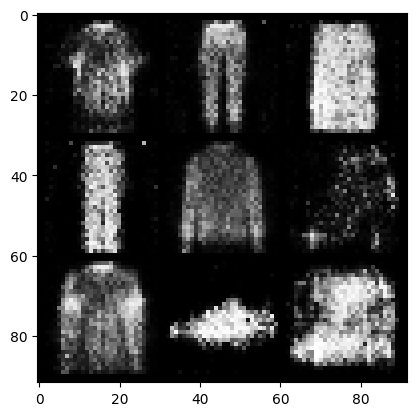

Starting epoch 24...
g_loss: 1.559795618057251, d_loss: 0.9950283169746399


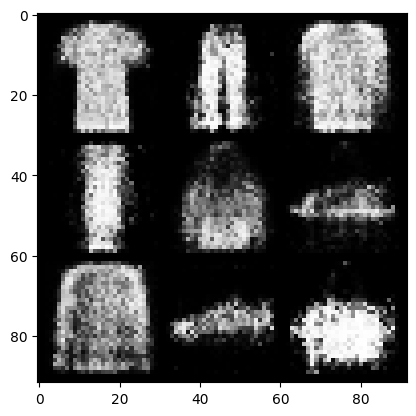

Starting epoch 25...
g_loss: 1.4903252124786377, d_loss: 0.7205760478973389


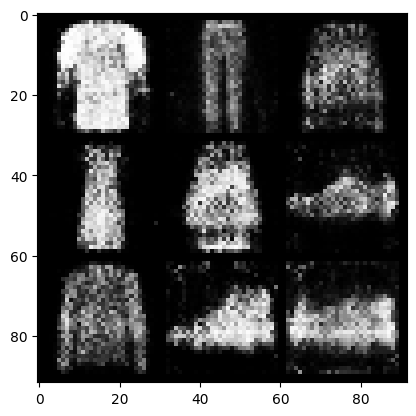

Starting epoch 26...
g_loss: 1.6416854858398438, d_loss: 0.9587173461914062


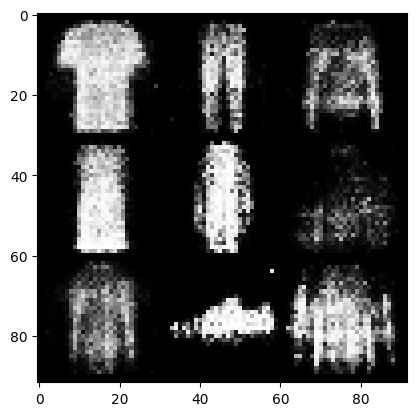

Starting epoch 27...
g_loss: 1.4469215869903564, d_loss: 0.5533724427223206


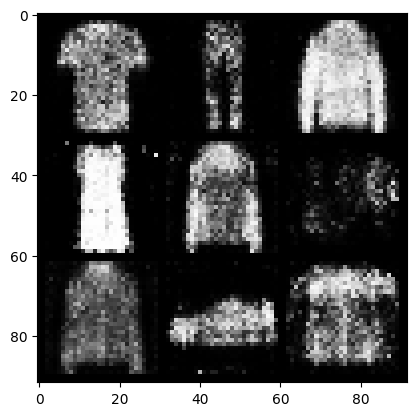

Starting epoch 28...
g_loss: 1.6099721193313599, d_loss: 0.9348692893981934


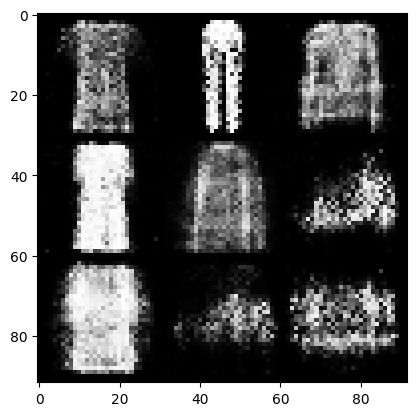

Starting epoch 29...
g_loss: 1.8578400611877441, d_loss: 0.9344573020935059


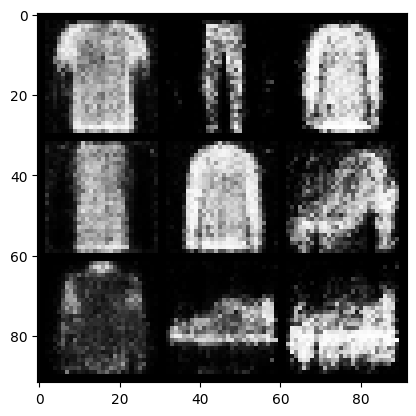

Starting epoch 30...
g_loss: 1.7169663906097412, d_loss: 0.7333542108535767


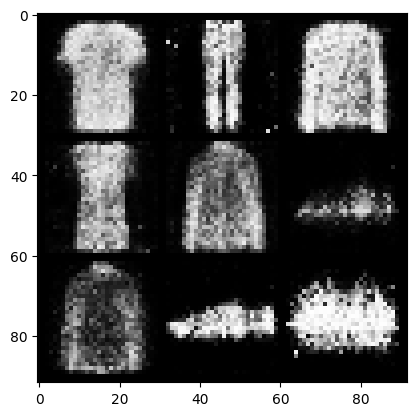

In [27]:
for epoch in range(epochs):

    print('Starting epoch {}...'.format(epoch+1))

    for i, (images, labels) in enumerate(data_loader):

        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set generator train
        generator.train()

        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)

        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    # Set generator eval
    generator.eval()

    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    # Building z
    z = Variable(torch.randn(class_num-1, z_size)).to(device)

    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)

    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

<p style="font-family:Roboto; font-size: 22px; color: orange; text-decoration-line: overline; "> Part: _Show Generating Images</p>

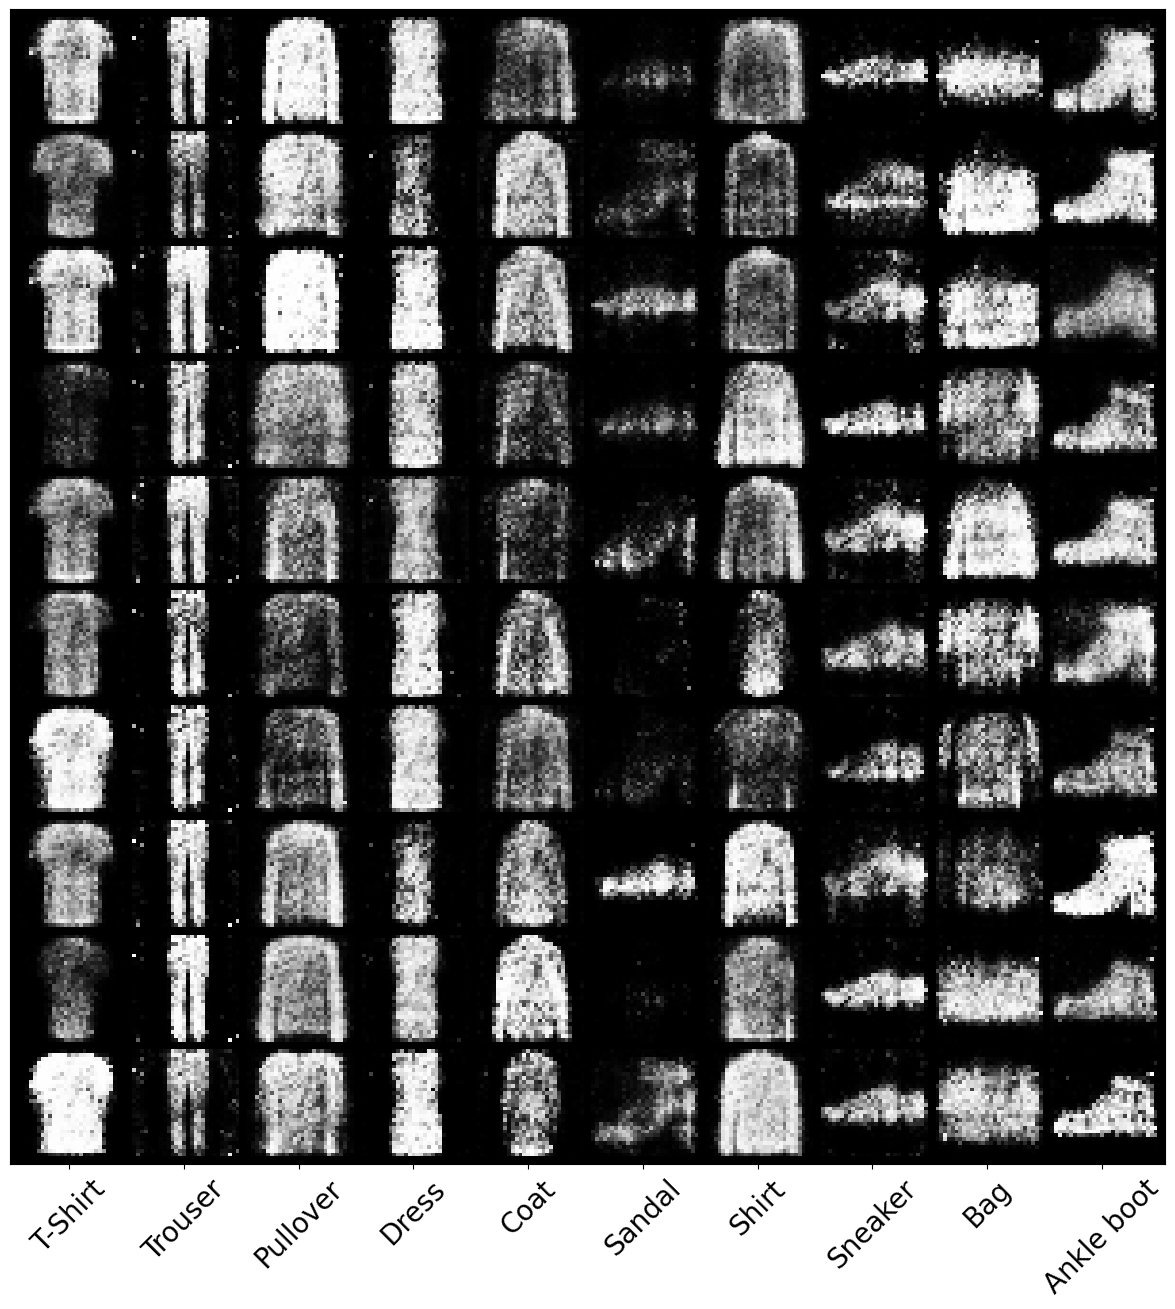

In [28]:
# Building z
z = Variable(torch.randn(z_size, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)